In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/edu-data")
!ls

df_video_with_country_nonan.csv        stem_video_titles_tags_50.xlsx
final_keywords.txt		       video_with_channelcountry.csv
is_stem_column_0.csv		       video_with_channelcountry.csv.zip
is_stem_column_30percent.csv	       video_with_country_and_stem.csv
keyword_counts.txt		       video_with_stem_cutoffs.csv
__MACOSX			       video_with_stem_cutoffs_post0.csv
no_econ_no_game_final_keywords.txt     video_with_stem_titles_and_cutoffs.csv
stem_video_titles_tags_0.xlsx	       video_with_stem_titles.csv
stem_video_titles_tags_30percent.xlsx


In [3]:
# Install required packages
! pip3 install polars rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 26.8 MB/s eta 0:00:00


In [4]:
import csv
import re

import numpy as np
import pandas as pd
import polars as pl

import seaborn as sns
import matplotlib.pyplot as plt

from rapidfuzz import fuzz, process
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

This time we set a higher fuzzy matching threshold (90%) and no tag match ratio (i.e only need 1 tag matched to keyword list).

In [5]:
# Function to extract unique keywords from a file
def extract_keywords(filepath):
    """
    Extracts unique keywords from a file with the format "x_keywords: [...]".
    """
    keywords = {}
    with open(filepath, 'r') as file:
        for line in file:
            match = re.match(r"(\w+_keywords)\s*=\s*\[(.*?)\]", line, re.DOTALL)
            if match:
                category = match.group(1)
                keyword_str = match.group(2)
                # Handle both single and double quotes, special characters, and filter empty strings
                keyword_list = [''.join(k).strip().strip("'").strip('"').strip("’") for k in re.findall(r"'([^']*)'|[\"]([^\"]*)[\"]|’([^’]*)’", keyword_str)]
                keyword_list = [keyword for keyword in keyword_list if keyword]
                keywords[category] = keyword_list

    # Flatten the dictionary and remove duplicates
    all_keywords = []
    for category, wordlist in keywords.items():
        all_keywords.extend(wordlist)

    return list(set(all_keywords))

def preprocess(text):
    return re.sub(r'[^a-z0-9 ]', '', text.lower().strip())

stem_keywords = extract_keywords('/content/drive/MyDrive/edu-data/final_keywords.txt')
stem_keywords_lower = [preprocess(keyword) for keyword in stem_keywords]
len(stem_keywords)

1985

In [6]:
# Load video data with country field using Polars
df_video_with_country = pl.read_csv('/content/drive/MyDrive/edu-data/video_with_channelcountry.csv')
df_video_with_country = df_video_with_country.filter(pl.col("country").is_not_null())

In [7]:
def preprocess_texts(texts):
    """Preprocess a list of texts by converting to lowercase and stripping whitespace."""
    return [text.lower().strip() for text in texts if text and text.strip()]

# -----------------------------
# Classifying STEM titles
# -----------------------------
def is_stem_title(title_batch, stem_keywords, fuzzy_threshold=90):
    """
    Checks if video titles are STEM-related using fuzzy matching, optimized for speed with process.cdist.

    Args:
        title_batch (list of str): A batch of video titles.
        stem_keywords (list of str): A list of STEM-related keywords.
        fuzzy_threshold (int): The minimum similarity score to consider a match (0-100).

    Returns:
        list of bool: True if a title matches any STEM keyword with sufficient similarity, False otherwise.
    """
    results = []
    for title in title_batch:
        if not title or title.strip() == "":
            results.append(False)
            continue

        normalized_title = title.lower()

        # Compute similarity scores between the title and all stem_keywords
        scores = process.cdist([normalized_title], stem_keywords, scorer=fuzz.ratio, score_cutoff=fuzzy_threshold)

        # Check if any score exceeds the threshold
        match_found = np.any(scores >= fuzzy_threshold)
        results.append(match_found)

    return results

# Example usage
stem_keywords_lower_test = ["dna", "protein", "quantum", "algorithm", "physics", "math", "biology", "engineering"]

video_titles = [
    "dnaprotein interacton this is how you do it! best solution ever new lecture 2024",
    "Learn quantum physics in 10 minutes!",
    "Cooking with pasta: a new recipe",
    ""
]

print("STEM-related results:", is_stem_title(video_titles, stem_keywords_lower_test))

# -----------------------------
# Classifying videos by STEM tag ratios
# -----------------------------
def count_tags_and_evaluate_cutoffs(tags_batch, cutoffs, stem_keywords, fuzzy_cutoff=90):
    """
    Checks if the percentage of matching tags exceeds each cutoff ratio using fuzzy matching.

    Args:
        tags_batch (list of str): A batch of tag lists (each entry is a string of comma-separated tags).
        cutoffs (list of float): List of cutoff ratios (e.g., 0.5 for 50%).
        stem_keywords (list of str): A list of STEM-related keywords.
        fuzzy_cutoff (int): The minimum similarity score to consider a match (0-100).

    Returns:
        list of lists: A list of boolean lists, each indicating if the tag match percentage exceeds each cutoff.
    """
    results = []

    for tags in tags_batch:
        if not tags or tags.strip() == "":
            results.append([False] * len(cutoffs))
            continue

        # Preprocess tags: split by commas and normalize
        video_tags = [tag.strip().lower() for tag in tags.split(",") if tag.strip()]
        total_tags = len(video_tags)

        if total_tags == 0:
            results.append([False] * len(cutoffs))
            continue

        # Compute similarity scores in batch using process.cdist
        scores = process.cdist(video_tags, stem_keywords, scorer=fuzz.ratio, score_cutoff=fuzzy_cutoff)

        # Count the number of tags that meet the fuzzy cutoff threshold
        matched_tags = np.sum(np.any(scores >= fuzzy_cutoff, axis=1))

        # Calculate the percentage of matching tags
        match_percentage = matched_tags / total_tags

        # Check if the match percentage exceeds each cutoff
        results.append([match_percentage >= cutoff for cutoff in cutoffs])

    return results

# Example usage
stem_keywords_lower_test = ["dna", "protein", "quantum", "algorithm", "physics", "math", "biology", "engineering"]
cutoff_ratios = [0.5]  # Equivalent to 50% threshold

tags_batch = [
    "quantum teck, dnaprotein interacton, some tag, some other tag",  # Should match >50%
    "math tutorial, physics concepts, cooking recipe",                # Should match >50%
    "funny video, comedy skit",                                        # Should not match
    ""                                                                # Empty tags
]

print("STEM-related results:", count_tags_and_evaluate_cutoffs(tags_batch, cutoff_ratios, stem_keywords_lower_test))

STEM-related results: [False, False, False, False]
STEM-related results: [[False], [False], [False], [False]]


In [8]:
# -----------------------------
# Main Processing Pipeline
# -----------------------------
def process_videos(df, stem_keywords, cutoffs, chunk_size=1000):
    num_chunks = (len(df) + chunk_size - 1) // chunk_size
    title_results = []
    tag_results = []

    # Preprocess titles and tags before parallel processing
    df = df.with_columns([
        pl.col("title").fill_null("").str.strip_chars().str.to_lowercase(),
        pl.col("tags").fill_null("").str.strip_chars().str.to_lowercase()
    ])

    with ThreadPoolExecutor() as executor:
        # Process titles in parallel
        title_futures = [
            executor.submit(is_stem_title, df["title"][i * chunk_size : (i + 1) * chunk_size], stem_keywords)
            for i in range(num_chunks)
        ]

        # Process tags in parallel
        tag_futures = [
            executor.submit(count_tags_and_evaluate_cutoffs, df["tags"][i * chunk_size : (i + 1) * chunk_size], cutoffs, stem_keywords)
            for i in range(num_chunks)
        ]

        # Collect title results
        for future in tqdm(title_futures, desc="Evaluating STEM Titles"):
            title_results.extend(future.result())

        # Collect tag results
        for future in tqdm(tag_futures, desc="Evaluating STEM Tags with Cutoffs"):
            tag_results.extend(future.result())

    # Add title results as a new column
    df = df.with_columns(pl.Series("is_stem_title", title_results))

    # Convert tag results to a DataFrame with cutoff columns
    cutoff_columns = [f'is_stem_cutoff_{int(cutoff * 100)}' for cutoff in cutoffs]
    cutoff_results_df = pl.DataFrame(tag_results, schema=cutoff_columns)

    # Combine the results with the original DataFrame
    df_combined = df.hstack(cutoff_results_df)

    return df_combined

In [15]:
cutoff_ratios = [0.2, 0.3, 0.4, 0.5]

# Process the DataFrame
df_final = process_videos(df_video_with_country, stem_keywords_lower, cutoff_ratios)

# Save the final DataFrame to a CSV
df_final.write_csv("/content/drive/MyDrive/edu-data/video_with_stem_titles_and_cutoffs1.csv")

Evaluating STEM Tags with Cutoffs: 100%|██████████| 1912/1912 [20:47<00:00,  1.53it/s]
/usr/lib/python3.10/functools.py:889: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  return dispatch(args[0].__class__)(*args, **kw)


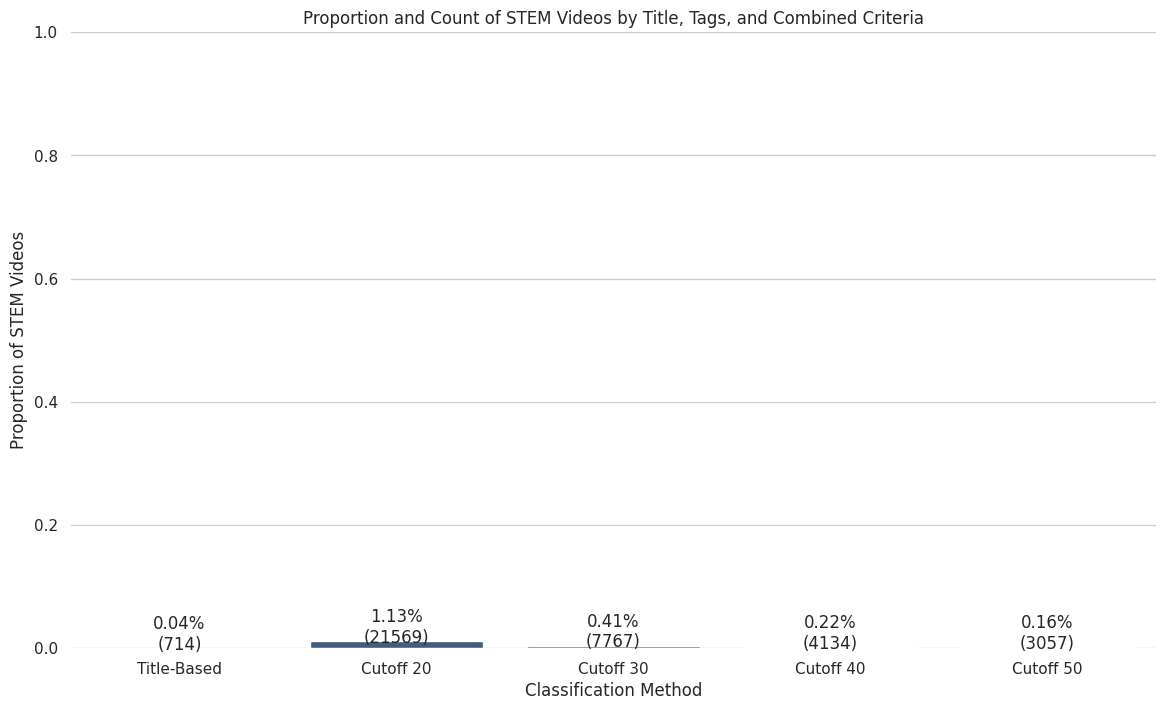

In [19]:
# Load the processed DataFrame
df_video_with_stem_titles_tags = pl.read_csv("/content/drive/MyDrive/edu-data/video_with_stem_titles_and_cutoffs1.csv")

# List of tag-based cutoff columns and the combined column
cutoff_columns = ["is_stem_cutoff_20", "is_stem_cutoff_30", "is_stem_cutoff_40", "is_stem_cutoff_50"]

# Calculate counts for tag-based STEM classifications
tag_stem_counts = {col: df_video_with_stem_titles_tags[col].sum() for col in cutoff_columns}

# Calculate the count for title-based STEM classification
title_stem_count = df_video_with_stem_titles_tags["is_stem_title"].sum()

# Convert counts to proportions
total_videos = len(df_video_with_country)
tag_stem_proportions = {key: count / total_videos for key, count in tag_stem_counts.items()}
title_stem_proportion = title_stem_count / total_videos

# Prepare data for plotting
plot_data = pd.DataFrame({
    "Category": ["Title-Based"] + [col.replace("is_stem_", "").replace("_", " ").title() for col in cutoff_columns],
    "Count": [title_stem_count] + list(tag_stem_counts.values()),
    "Proportion": [title_stem_proportion] + list(tag_stem_proportions.values())
})

# Plot the data
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid", palette="viridis")

# Create a bar plot
ax = sns.barplot(
    x="Category",
    y="Proportion",
    data=plot_data,
    hue="Category",
    dodge=False,
    legend=False
)

# Add annotations on each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2%}\n({int(p.get_height() * total_videos)})',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Customize plot appearance
plt.title("Proportion and Count of STEM Videos by Title, Tags, and Combined Criteria")
plt.xlabel("Classification Method")
plt.ylabel("Proportion of STEM Videos")
plt.ylim(0, 1)  # Set y-axis limit between 0 and 1
sns.despine(left=True, bottom=True)

# Show the plot
plt.show()

In [20]:
# Filter rows where 'is_stem_title' is True
stem_videos = df_video_with_stem_titles_tags.filter((pl.col("is_stem_title") == True) | (pl.col("is_stem_cutoff_20") == True))

# Randomly sample 100 STEM videos (or fewer if less than 100 are available)
sampled_stem_videos = stem_videos.sample(n=min(100, len(stem_videos)), seed=42)

# Print titles and tags
for row in sampled_stem_videos.iter_rows(named=True):
    print(f"Title: {row['title']}")
    print(f"Tags: {row['tags']}")
    print("-" * 20)

Title: joint play w/ lynn wind - sample of her class
Tags: lynn,wind,joint,play
--------------------
Title: how to solve abo blood type problems 6
Tags: abo blood type,genetics
--------------------
Title: l09.7 joint pdfs
Tags: joint pdfs
--------------------
Title: mitochondria the site of respiration
Tags: mitochondria,respiration,cell,eukaryotic,prokaryotic
--------------------
Title: (1 of 2) electricity and magnetism - review of all topics - ap physics c
Tags: ap,physics,calculus,lecture,electricity,magnetism,review,electric,force,field,flux,gauss,law,potential,energy,difference,capacitance,resistance,resistivity,power,emf,electromotive,terminal,voltage,current,kirchhoff,rules,rc,circuit,review,electricity,electromagnetism,magnetism,crash course
--------------------
Title: comparing multi digit numbers word problems
Tags: education,online learning,learning,lessons
--------------------
Title: l23.4 symmetric and antisymmetric states of n particles
Tags: identical particles,symmetri